In [1]:
# Import Libraries

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction import DictVectorizer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from xgboost import XGBRegressor

# from tqdm.auto import tqdm  # ✅ progress bar

## Load Data 

In [2]:
# Import data 
data  = pd.read_csv('data/insurance.csv')
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [4]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Exploratory Data Analysis

#### Check for null values

In [5]:
data.isnull().sum() # Dataset is clean 

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [6]:
#Check for duplicate
data.duplicated().sum()

np.int64(1)

In [7]:
data=data.drop_duplicates(keep='first')
len(data)

1337

In [8]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numeric_cols, categorical_cols

(['age', 'bmi', 'children', 'charges'], ['sex', 'smoker', 'region'])

In [9]:
# Remove target valriable
numeric_cols.remove('charges')

Visual Analysis

In [66]:
# Applying a default style for all plots
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams["figure.figsize"] = (8, 5)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15964\2068544251.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x = col, palette='Set2')


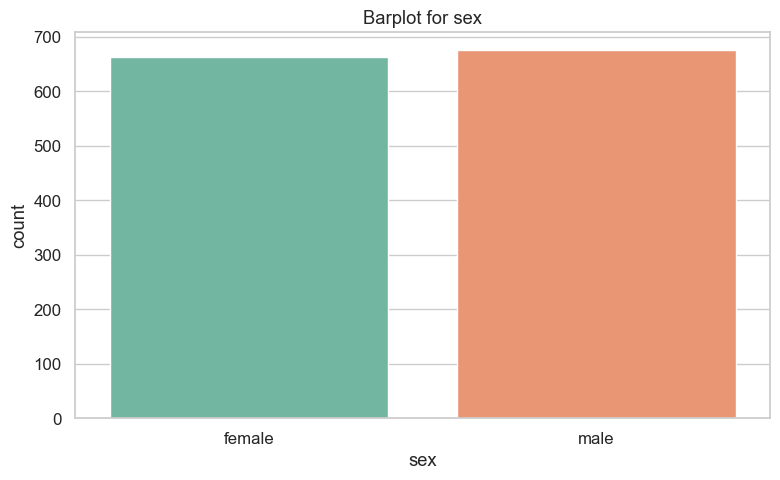

C:\Users\Admin\AppData\Local\Temp\ipykernel_15964\2068544251.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x = col, palette='Set2')


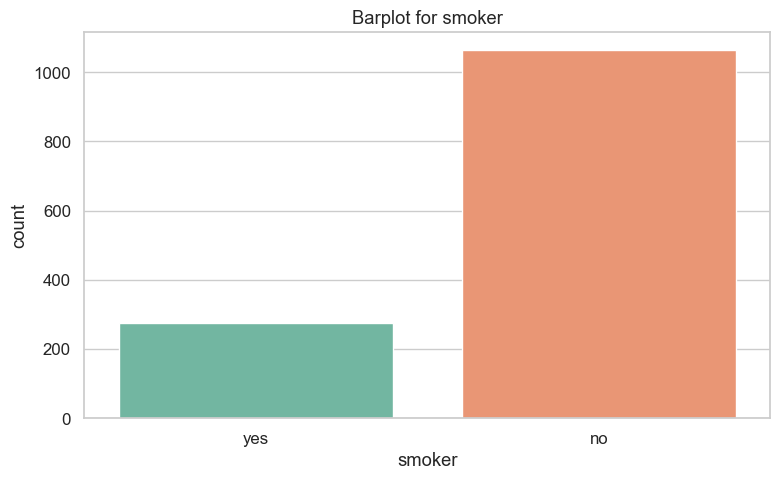

C:\Users\Admin\AppData\Local\Temp\ipykernel_15964\2068544251.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x = col, palette='Set2')


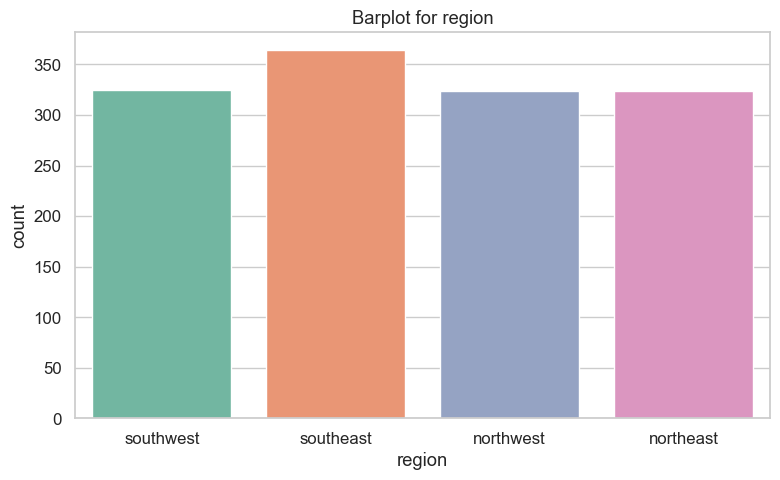

In [71]:
# Visualize the distribution of categorical columns using barplots
for col in categorical_cols:
    sns.countplot(data=data, x = col, palette='Set2')
    plt.title(f"Barplot for {col}")
    plt.tight_layout()
    plt.show()

C:\Users\Admin\AppData\Local\Temp\ipykernel_15964\1658460209.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x="children",  palette='Set1')


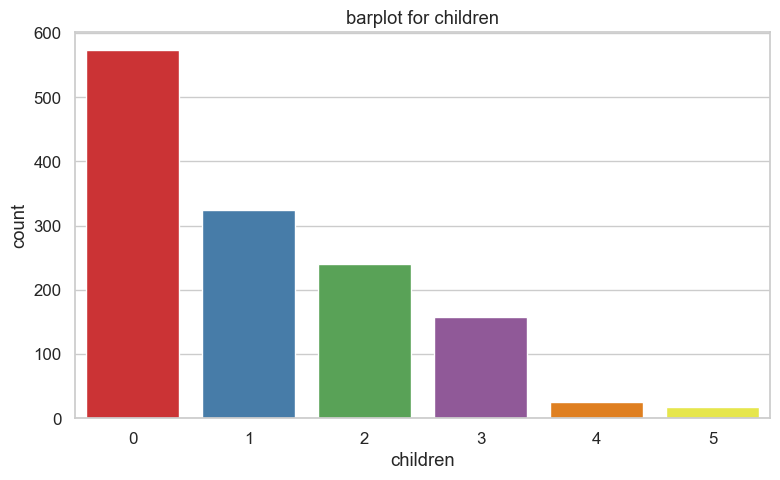

In [74]:
sns.countplot(data=data, x="children",  palette='Set1')
plt.title("barplot for children")
plt.tight_layout()
plt.show()

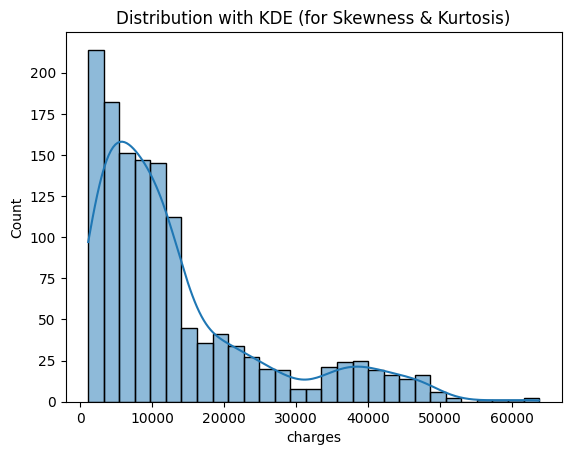

In [63]:
sns.histplot(data['charges'], kde=True)
plt.title('Distribution with KDE (for Skewness & Kurtosis)')
plt.show()

<Axes: xlabel='charges'>

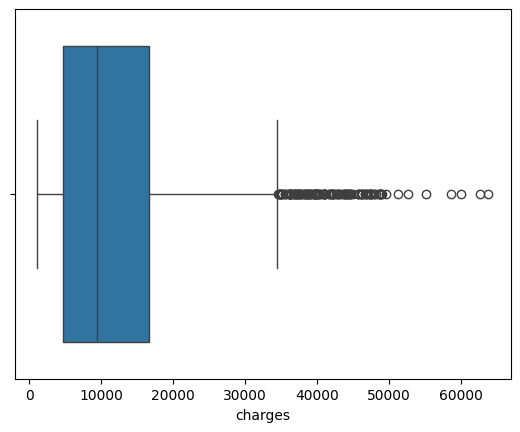

In [65]:
# outliers of target

sns.boxplot(x ='charges' , data=data)

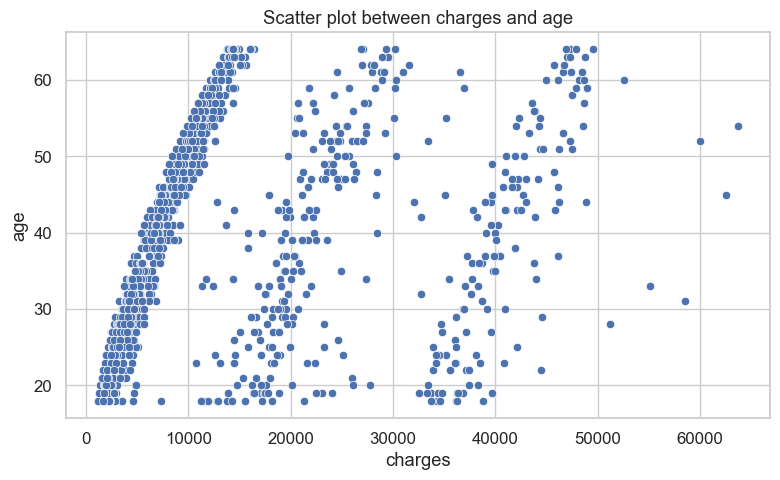

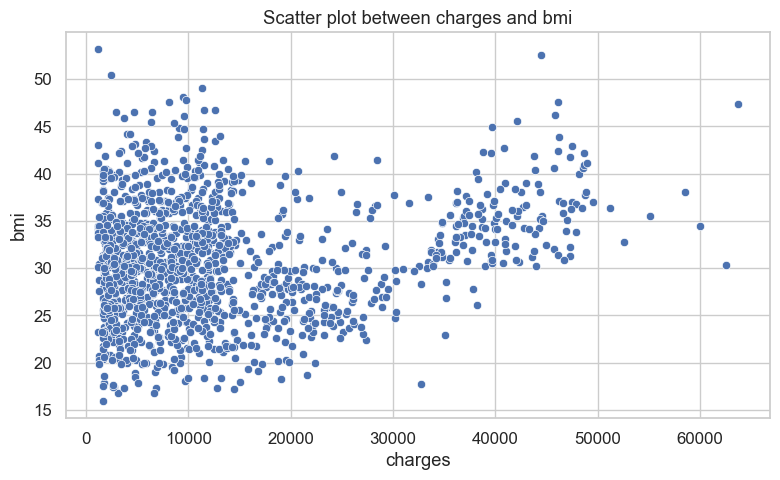

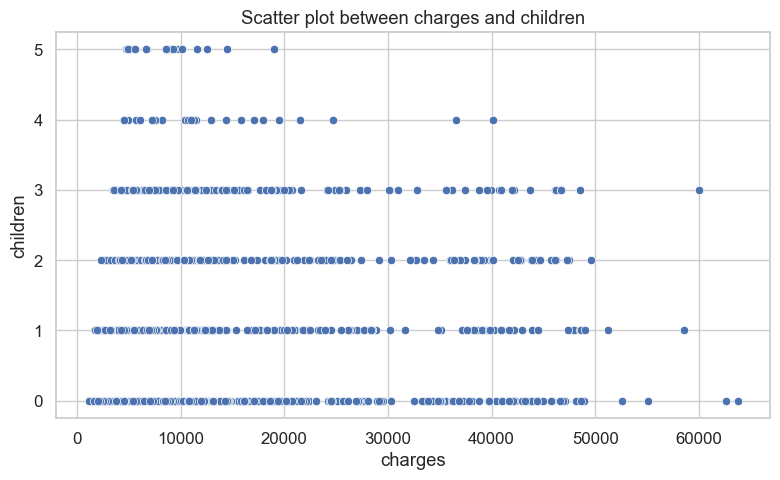

In [75]:
for col in numeric_cols:
    sns.scatterplot(data=data, x="charges", y=col)
    plt.title(f"Scatter plot between charges and {col}")
    plt.tight_layout()
    plt.show()

In [10]:
#Checking for outliers
for col in numeric_cols:
    initial_skew = data[col].skew(skipna=True)
    print(initial_skew)

0.054780773126998195
0.28391419385321137
0.9374206440474123


In [11]:

for n in numeric_cols:
    print(data[n].describe())
    print()

count    1337.000000
mean       39.222139
std        14.044333
min        18.000000
25%        27.000000
50%        39.000000
75%        51.000000
max        64.000000
Name: age, dtype: float64

count    1337.000000
mean       30.663452
std         6.100468
min        15.960000
25%        26.290000
50%        30.400000
75%        34.700000
max        53.130000
Name: bmi, dtype: float64

count    1337.000000
mean        1.095737
std         1.205571
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: children, dtype: float64



In [12]:
for col in categorical_cols:
    print(data[col].value_counts())
    print()


sex
male      675
female    662
Name: count, dtype: int64

smoker
no     1063
yes     274
Name: count, dtype: int64

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64



**Dataset is clean with no null values**

#### Split train, validation and test datasets

In [13]:
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [14]:
# Reset indices
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

# Extract target values
y_train = df_train['charges'].values
y_val = df_val['charges'].values
y_test = df_test['charges'].values

# Drop target column in-place
df_train.drop('charges', axis=1, inplace=True)
df_val.drop('charges', axis=1, inplace=True)
df_test.drop('charges', axis=1, inplace=True)

In [15]:
len(df_train), len(df_val), len(df_test)

(801, 268, 268)

In [16]:
df_train[numeric_cols]

,age,bmi,children
0,32,24.600,0
1,31,28.500,5
2,52,31.200,0
3,49,34.770,1
4,63,28.310,0
...,...,...,...
796,50,28.120,3
797,45,33.100,0
798,47,29.800,3
799,34,37.335,2


#### One Hot Encoding

In [17]:
dv = DictVectorizer(sparse=False)
train_dict = df_train[categorical_cols + numeric_cols].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical_cols + numeric_cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [18]:
df_train.head(1)

,age,sex,bmi,children,smoker,region
0,32,female,24.6,0,yes,southwest


In [19]:
X_train[0]

array([32. , 24.6,  0. ,  0. ,  0. ,  0. ,  1. ,  1. ,  0. ,  0. ,  1. ])

#### Scaling 

In [20]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [21]:
X_train_scaled[0]

array([-0.53550805, -0.98533655, -0.91640916, -0.563413  , -0.55956658,
       -0.60571792,  1.72201816,  1.04208325, -1.04208325, -1.8844459 ,
        1.8844459 ])

## Train Models

**I am training in 4 different models like Linear Regression, Random Forest, Gradient Boosting and XGBoost**

In [22]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest" : RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting" : GradientBoostingRegressor(n_estimators=100,random_state=42),
    "XGBoost" : XGBRegressor(
        n_estimators = 100,
        objective = 'reg:squarederror',
        eval_metric ='rmse',
        random_state = 42       
    )
}

In [25]:
# Method to find the base result. Based on these result, I can select which model is perfmoring well for parameter tuning
def FindBaseModel(models, X_train_scaled, y_train, X_val_scaled, y_val):
    baseline_results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        pred = model.predict(X_val_scaled)

        rmse = root_mean_squared_error(y_val, pred)
        r2 = r2_score(y_val, pred)
        mae = mean_absolute_error(y_val, pred)
        baseline_results[name]={"RMSE": rmse, "MAE": mae, "R2": r2}

    return baseline_results


In [ ]:

results = FindBaseModel(models, X_train_scaled, y_train, X_val_scaled, y_val)
results = pd.DataFrame(results).T
results = results.sort_values(by='RMSE')
print(results)

                          RMSE          MAE        R2
Gradient Boosting  5031.214029  2732.332233  0.824352
Random Forest      5210.640841  2879.373157  0.811600
XGBoost            5760.640248  3235.065550  0.769729
Linear Regression  6196.214606  4338.690576  0.733590


### Hyperparameter Tuning

**From the above result, I select Random Forest and Gradient Boosting models for fine tuning**

In [58]:
#Random Forest Parameter Grid

rf_param_grid = {
    'n_estimators':[100, 200, 250, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)
rf_random_search = RandomizedSearchCV(estimator=rf,
                                      param_distributions=rf_param_grid,
                                      n_iter=20,
                                      scoring='neg_root_mean_squared_error',
                                      cv=3,
                                      verbose=2,
                                      random_state=42,
                                      n_jobs=-1)
rf_random_search.fit(X_train_scaled, y_train)
print("Random Forest Regressor: ")
print("Best RF params: ", rf_random_search.best_params_)
print("Best RF RMSE: ", rf_random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Random Forest Regressor: 
Best RF params:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 10}
Best RF RMSE:  -4604.3681893102


In [59]:
best_estimator_rf = rf_random_search.best_estimator_
print("Best Estimator for Random Forest Model: ", best_estimator_rf)
print()

pred =best_estimator_rf.predict(X_val_scaled)
rmse = root_mean_squared_error(y_val, pred)
r2 = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred)
print("Random Forest Regressor: ")
print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

Best Estimator for Random Forest Model:  RandomForestRegressor(max_depth=10, min_samples_leaf=4, min_samples_split=10,
                      n_estimators=200, random_state=42)

Random Forest Regressor: 
RMSE: 4997.327796005624, MAE: 2729.192806072154, R2: 0.8267101292810783


In [60]:
#Gradient Boosting Parameter Grid

gb_param_grid = {
    'n_estimators':[100, 200, 250, 300, 400],
    'max_depth': [3, 5, 6, 7, 9],
    'learning_rate': [0.01, 0.05, 0.5, 0.1],
    'subsample': [0.6, 0.8, 1.0]
}

gb = GradientBoostingRegressor(random_state=42)
gb_random_search = RandomizedSearchCV(estimator=gb,
                                      param_distributions=gb_param_grid,
                                      n_iter=20,
                                      scoring='neg_root_mean_squared_error',
                                      cv=3,
                                      verbose=2,
                                      random_state=42,
                                      n_jobs=-1)
gb_random_search.fit(X_train_scaled, y_train)
print("Gradien Bossting Regressor: ")
print("Best gb params: ", gb_random_search.best_params_)
print("Best gb RMSE: ", gb_random_search.best_score_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Gradien Bossting Regressor: 
Best gb params:  {'subsample': 0.6, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01}
Best gb RMSE:  -4615.317232319051


In [61]:
best_estimator_gb = gb_random_search.best_estimator_
print("Best Estimator for Gradient Boosting Model: ", best_estimator_gb)
print()

pred =best_estimator_gb.predict(X_val_scaled)
rmse = root_mean_squared_error(y_val, pred)
r2 = r2_score(y_val, pred)
mae = mean_absolute_error(y_val, pred)
print("Gradient Boosting Regressor: ")
print(f"RMSE: {rmse}, MAE: {mae}, R2: {r2}")

Best Estimator for Gradient Boosting Model:  GradientBoostingRegressor(learning_rate=0.01, n_estimators=300, random_state=42,
                          subsample=0.6)

Gradient Boosting Regressor: 
RMSE: 4891.90665283615, MAE: 2781.0534414159943, R2: 0.8339442857319842


**In this hyperparameter tuning, gradient boosting is doing better than Random forest. So I am selecting Random Forest Regressor as my final model**

In [52]:
gb_random_search.best_estimator_.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.01,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 0.6,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Test Dataset

In [54]:
# Combine training and validation dataset
x_train_full = np.vstack([X_train_scaled, X_val_scaled])
y_train_full = np.concatenate([y_train, y_val])
len(x_train_full), len(y_train_full)

(1069, 1069)

In [ ]:
test_dict = df_test[categorical_cols + numeric_cols].to_dict(orient='records')
X_test = dv.fit_transform(test_dict)
X_test_scaled = scaler.transform(X_test)

In [56]:
best_estimator_gb.fit(x_train_full, y_train_full)
pred = best_estimator_gb.predict(X_test_scaled)

rmse = root_mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("Prediction in Test Dataset using Gradient Boosting Regressor:")
print(f"RMSE: {rmse}, R2: {r2}")

Prediction in Test Dataset using Gradient Boosting Regressor:
RMSE: 4180.342460009358, R2: 0.8649096554855318
